## Sound Detection

---


This notebook aims to benchmark some methods of sound detection and determine the best method on the basis on a precision mesure.

In this work, we will follow these steps :
*   explain what is a sound  et in how many ways we can represent it (time domain, frequency domain and spectrograms).

*   present two methods of sound detection : the first based on the interorrelation of two signals and the second based on the spectrogram.

*   define our precision criteria and evaluate the method on a labeled dataset.

*   conclude on the best method and *describe* further insights.



In [41]:
!pip install pyAudioAnalysis
!pip install pydub
!pip install eyed3
!pip install hmmlearn
from google.colab import output
output.clear()

In [2]:
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from pyAudioAnalysis import MidTermFeatures as aFm
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis.ShortTermFeatures import feature_extraction as aF
import moviepy.editor as mp
from pydub import AudioSegment
import os
import cv2
import pyAudioAnalysis.audioSegmentation as aS
from scipy.io.wavfile import read
import pandas as pd
from moviepy.editor import *
from moviepy.audio.AudioClip import AudioArrayClip

In [14]:
from google.colab import files
uploaded = files.upload()

Saving test.zip to test.zip


In [ ]:
mt = np.load("ref_features_bip.npy")
print(mt.shape)

(35, 136)


In [15]:
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: test/000007.mp4         
  inflating: test/000007.txt         
  inflating: test/000009.mp4         
  inflating: test/000009.txt         
  inflating: test/000011.mp4         
  inflating: test/000011.txt         
  inflating: test/000013.mp4         
  inflating: test/000013.txt         
  inflating: test/000015.mp4         
  inflating: test/000015.txt         
  inflating: test/000017.mp4         
  inflating: test/000017.txt         
  inflating: test/000019.mp4         
  inflating: test/000019.txt         
  inflating: test/000021.mp4         
  inflating: test/000021.txt         
  inflating: test/000023.mp4         
  inflating: test/000023.txt         
  inflating: test/000025.mp4         
  inflating: test/000025.txt         
  inflating: test/000027.mp4         
  inflating: test/000027.txt         
  inflating: test/000029.mp4         
  inflating: test/000029.txt         
  inflating: test/000031.mp4         
  inflating:

## What is a sound?


---
Sound is a temporal signal produced by ***variation of air pressure***. It has ***a variable intensity*** and can be represented with the ***frequencies*** that are contained in it.
Let's load a sound file and plot its representation in the time domain.


In [4]:
ball_bounce=Audio('ping.wav')
ball_bounce

This sound is a tennis table ball bounce on table. Let's see how the signal is displayed in the ***time domain***.


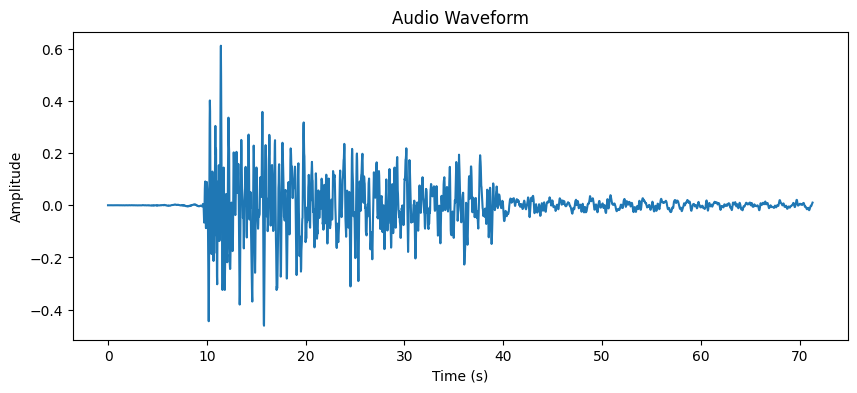

In [16]:
# Load the audio file
audio_path = 'ping.wav'
audio, sr = librosa.load(audio_path)

# Get the time axis in seconds
duration = len(audio) / sr
time = librosa.times_like(audio, sr=sr)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time, audio)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

As we can see, the signal is too complex and we can't extract from this waveform an intuitive information that would help us extract this sound and differentiate it from others.

Let's use ***Fast Fourier Transformation*** to visualize the frequencies present in our signal.

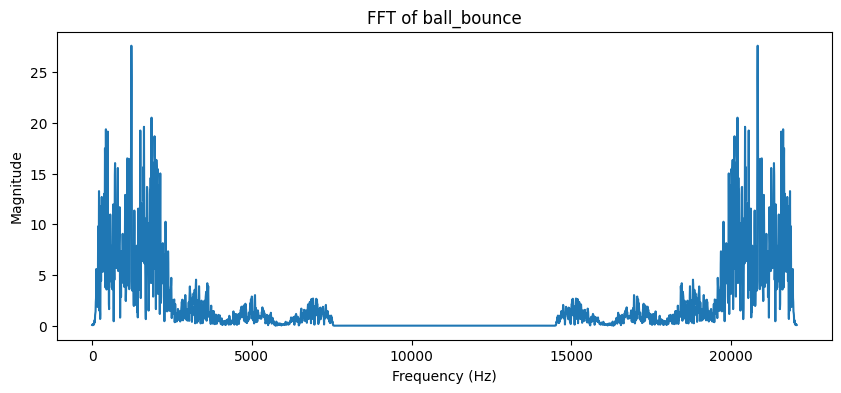

In [17]:
fft = np.fft.fft(audio)

# Compute the magnitude spectrum
magnitude = np.abs(fft)

# Create the frequency axis
freq = np.linspace(0, sr, len(magnitude))

# Plot the FFT
plt.figure(figsize=(10, 4))
plt.plot(freq, magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of ball_bounce')
plt.show()


We can see that the ball bounce is not a simple dirac or one peak. It's a signal that has a duration in time. We remark that this signal has multiple frequencies. Let's display the relevant frequencies

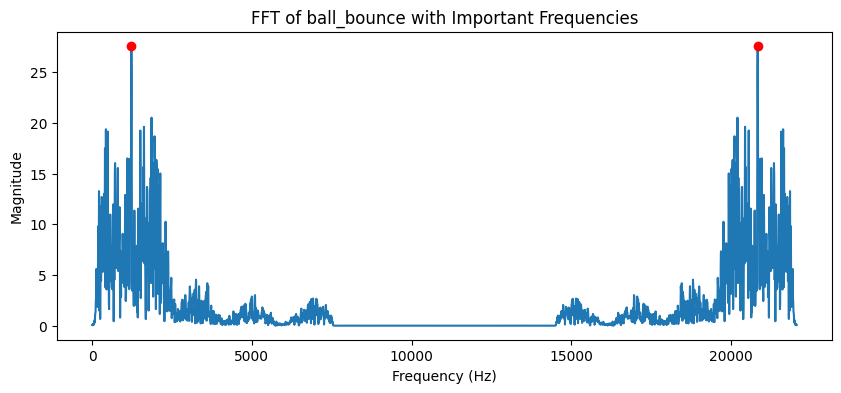

In [18]:
# Create the frequency axis
freq = np.linspace(0, sr, len(magnitude))

# Find peaks in the magnitude spectrum
peaks, _ = find_peaks(magnitude, distance=2000)  # Adjust the distance parameter as needed

# Select the corresponding frequencies
important_freq = freq[peaks]

# Plot the FFT with peaks
plt.figure(figsize=(10, 4))
plt.plot(freq, magnitude)
plt.plot(important_freq, magnitude[peaks], 'ro')  # Highlight the important frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of ball_bounce with Important Frequencies')
plt.show()


In [19]:
# important frequencies
important_freq

array([ 1227.79225008, 20829.38782156])

A signal may produce different sounds over time. So its spectrum varies over time. One way of representing uniquely a signal is to plot its ***spectrogram***.

***A Spectrogram*** of a signal plots its ***Spectrum*** over time and is like ***a photograph*** of the signal. It plots Time on the x-axis and Frequency on the y-axis. It is as though we took the Spectrum again and again at different instances in time, and then joined them all together into a single plot.

Let's plot the spectrogram of our ball bounce sound and analyze its aspects.

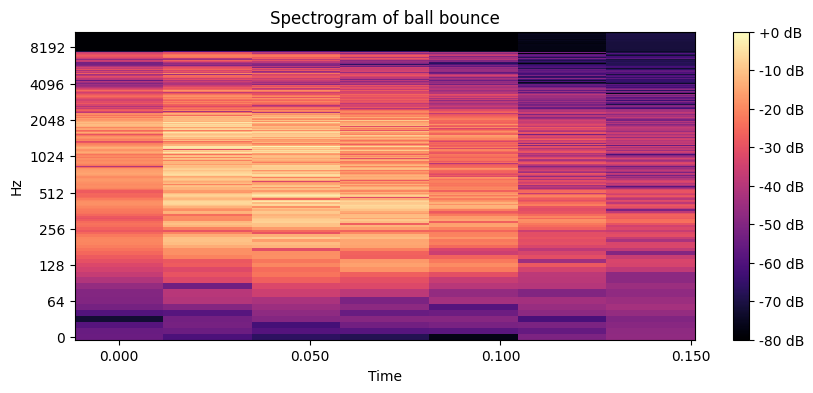

In [20]:
# Compute the spectrogram (use short time fourier transformation)
spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of ball bounce')
plt.show()

Now, since we presented several ways of seeing a sound signal, let's present the methods that we developped to detect a reference sound in a video or an audio file and measure their performance.

## Detection based on feature extraction

---

Here, we will  extract a reference sound from an audio or a video  by extracting the features of this sound file and stroing them in a numpy array (we will use ***Mel-frequency cepstral coefficients MFCC***). We will use the python library ***pyAudioAnalysis***.

<div style="display: flex; justify-content: center;"> <img src="https://github.com/tyiannak/pyAudioAnalysis/blob/master/icon.png?raw=true" alt="librosa logo" width="300" /> </div>

First, let's write a function that enables us to generate the features of a specific sound.

In [21]:
import soundfile as sf
def generate_features(file_path):
    # Load the audio file
    audio, sr = sf.read(file_path)

    # Extract features
    chroma_stft = librosa.feature.chroma_stft(S=audio, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    rms = librosa.feature.rms(y=audio)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)

    # Resize the features to the desired shape
    chroma_stft = resize_feature(chroma_stft, (136, 48))
    spectral_centroid = resize_feature(spectral_centroid, (136, 48))
    spectral_bandwidth = resize_feature(spectral_bandwidth, (136, 48))
    spectral_rolloff = resize_feature(spectral_rolloff, (136, 48))
    rms = resize_feature(rms, (136, 48))
    zero_crossing_rate = resize_feature(zero_crossing_rate, (136, 48))

    # Concatenate the features into a single feature vector
    feature_vector = np.concatenate(
        (chroma_stft, spectral_centroid, spectral_bandwidth, spectral_rolloff, rms, zero_crossing_rate),
        axis=0
    )

    return feature_vector

def resize_feature(feature, target_shape):
    # Use numpy's resize function to resize the feature
    resized_feature = np.resize(feature, target_shape)

    return resized_feature

In [22]:
data_path_in="./test/"
video = cv2.VideoCapture(data_path_in+"000007.mp4")
fps = video.get(cv2.CAP_PROP_FPS)
video.release()
def extract_first_bounce(data_path_in):
  first_bounces={}
  files=os.listdir(data_path_in)
  for file in files :
    if file.split('.')[-1]=='txt':
      with open(data_path_in+file,'r') as f:
        data=f.read()
        if data.split(',')[0]!='':
            first_bounces[file.split('.')[0]+'.mp4']=int(data.split(',')[0])/fps
  return first_bounces
first_bounces=extract_first_bounce(data_path_in)
first_bounces

{'000063.mp4': 1.48,
 '000041.mp4': 0.84,
 '000019.mp4': 2.24,
 '000043.mp4': 1.52,
 '000039.mp4': 3.84,
 '000023.mp4': 1.8,
 '000065.mp4': 2.04,
 '000011.mp4': 0.76,
 '000045.mp4': 0.08,
 'ECE-HARAC_vs_ARIANNA_BARANIset_1_point_5.mp4': 0.12,
 '000007.mp4': 0.4,
 '000053.mp4': 0.68,
 '000031.mp4': 0.32,
 '000025.mp4': 1.28,
 '000017.mp4': 0.36,
 '000033.mp4': 0.4,
 '000035.mp4': 1.16,
 'Alexis-Lebrun_vs_Banset_1_point_4.mp4': 2.16,
 '000029.mp4': 0.04,
 '000013.mp4': 1.04,
 '000015.mp4': 0.52,
 '000069.mp4': 1.72,
 '000071.mp4': 2.36,
 '000057.mp4': 0.4,
 '000061.mp4': 1.48,
 '000021.mp4': 2.92,
 '000037.mp4': 3.24,
 '000067.mp4': 1.16,
 'Alexis-Lebrun_vs_Banset_1_point_3.mp4': 3.04,
 '000055.mp4': 4.2,
 '000047.mp4': 0.08,
 '000027.mp4': 0.12,
 'Alexis-Lebrun_vs_Banset_1_point_2.mp4': 0.0,
 'ECE-HARAC_vs_ARIANNA_BARANIset_1_point_6.mp4': 0.04,
 '000051.mp4': 0.92,
 '000009.mp4': 0.04,
 'ECE-HARAC_vs_ARIANNA_BARANIset_1_point_4.mp4': 1.28,
 '000049.mp4': 0.72,
 '000059.mp4': 1.72}

Let's now try our method and plot its precision. The precision measure is for each video the gap between the labeled value of the first bounce and the value predicted by our method.

## Detection based on spectrograms

---



<img src="https://github.com/librosa/librosa/blob/main/docs/img/librosa_logo_text.png?raw=true" alt="librosa logo" width="300"/>

In [25]:
def detect_sound_ref_librosa(samples_path, video_name, ref_sound_name,threshold=50):
    # Load the target sound effect and the audio or video file
    target_sound_file = ref_sound_name
    audio_or_video_file = os.path.join(samples_path, video_name)
    # Load the target sound effect
    target_sound, sr = librosa.load(target_sound_file)
    target_sound = np.array(target_sound)
    # Load the audio or video file
    audio, sr1 = librosa.load(audio_or_video_file)
    length_video = int(len(audio) * 1000 / sr1)

    segment_duration = int(len(target_sound) * 1000 / sr)
    # Convert the target sound effect to a spectrogram
    target_sound_spec = librosa.amplitude_to_db(
        np.abs(librosa.stft(target_sound, hop_length=512)), ref=np.max
    )
    # Split the audio into short segments and compare them with the target sound effect  # Convert milliseconds to seconds)
    segment_length = segment_duration
    l = []
    for i in range(0, length_video - segment_length, segment_length):
        # Extract a segment from the audio
        segment = audio[i : i + segment_length]

        # Convert the segment to a spectrogram using librosa
        segment_spec = librosa.amplitude_to_db(
            np.abs(librosa.stft(segment, hop_length=512)), ref=np.max
        )

        # Compare the spectrograms of the segment and target sound effect
        resized_target_sound_spec = np.resize(target_sound_spec, segment_spec.shape)

        # Compare the spectrograms of the segment and target sound effect
        similarity = np.mean(np.abs(segment_spec - resized_target_sound_spec))

        # Set a threshold to determine if the target sound effect is present
          # Adjust this value based on your requirements

        if similarity < threshold:
            l.append(i / 1000)
    return l


In [27]:
samples_path="./test"
real_first_ball_bounces=[]
predicted_first_ball_bounces=[]
for file in os.listdir(samples_path):
    if file.endswith('.mp4'):
        start=detect_sound_ref_librosa(samples_path,file,"ping.wav")
        predicted_first_ball_bounces.append(start[1] if len(start)>1 else float('inf'))
        real_first_ball_bounces.append(first_bounces[file])
output.clear()
predicted_first_ball_bounces

[0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139,
 0.139]

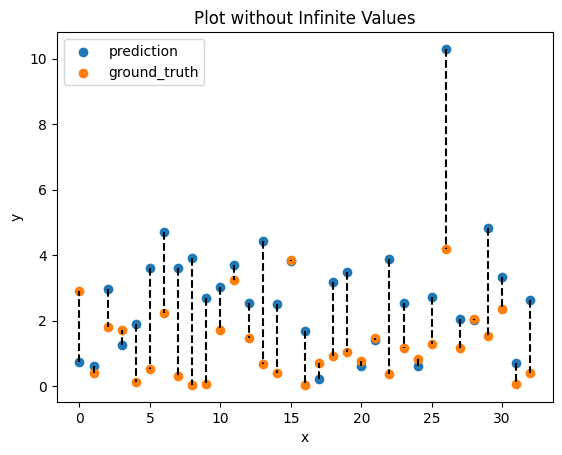

In [39]:
import matplotlib.pyplot as plt

x_coords = range(len(predicted_first_ball_bounces))

# Generate the plot
plt.scatter(x_coords, predicted_first_ball_bounces,label="prediction")
plt.scatter(x_coords, real_first_ball_bounces,label="ground_truth")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Plot without Infinite Values')

# Link points with the same x-coordinates
for x, predicted_y, real_y in zip(x_coords, predicted_first_ball_bounces, real_first_ball_bounces):
    plt.plot([x, x], [predicted_y, real_y], 'k--')

plt.show()

In [38]:
import numpy as np
import librosa

# Read the reference sound signal
reference_path = "ping.wav"
reference_signal, reference_sample_rate = librosa.load(reference_path, sr=None)
predicted_first_ball_bounces=[]
# Read the longer sound signal
for video_path in os.listdir("./test"):
  if video_path.endswith(".mp4"):
      video_path = os.path.join("./test",video_path)
      video = mp.VideoFileClip(video_path)
      audio_signal = video.audio.to_soundarray()[:, 0]

      # Perform cross-correlation
      cross_correlation = np.correlate(audio_signal, reference_signal, mode='valid')

      # Find the index of the maximum correlation
      max_correlation_index = np.argmax(cross_correlation)
      output.clear()
      # Print the index and correlation value
      predicted_first_ball_bounces.append(max_correlation_index/reference_sample_rate)

      # Read the video and extract the audio signal  # Extract audio signal from the video (assuming mono)

      # Calculate the correlation with each window

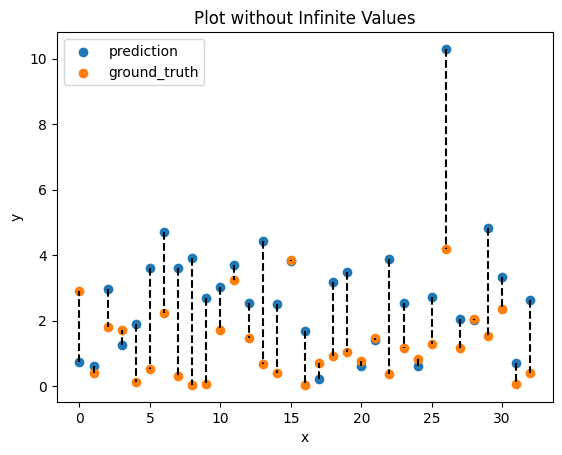

In [40]:
import matplotlib.pyplot as plt

x_coords = range(len(predicted_first_ball_bounces))

# Generate the plot
plt.scatter(x_coords, predicted_first_ball_bounces,label="prediction")
plt.scatter(x_coords, real_first_ball_bounces,label="ground_truth")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Plot without Infinite Values')

# Link points with the same x-coordinates
for x, predicted_y, real_y in zip(x_coords, predicted_first_ball_bounces, real_first_ball_bounces):
    plt.plot([x, x], [predicted_y, real_y], 'k--')

plt.show()

The second method shows reliable detections of ball_bounces. So we can use it to build a first system of sound detection which guarantees good results (in average).

We can do the same workflow on the detection of start sound in swimming competitions.